<a href="https://colab.research.google.com/github/irfanimaduddin/membership-hdbscan-gmm/blob/main/part2_gmm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hands-On: Open Cluster Membership Determination using Hierarchical Density-Based Spatial Clustering of Applications with Noise (HDBSCAN) and Gaussian Mixture Model (GMM) - Part 2** 

Authors : Salma Zahra Fadiyah, Irfan Imaduddin,  M. Ikbal Arifyanto <br>
Version : 1.0 <br>
Date : 22 July 2021 <br>
Contact : salmazahraa[at]gmail[dot]com <br>

---

## Welcome!

<p align = "justify">  In this workshop, we will determine the cluster members of an open cluster using Hierarchical Density-Based Spatial Clustering of Applications with Noise (HDBSCAN) and Gaussian Mixture Model (GMM). This is the second part of two hands-on series. The first part has held yesterday (20/08/07). The open cluster data that will be used is NGC 752 from Gaia Early Data Release 3 (eDR3). </p> 

Hands-on part one: [day06_handson_hdbscan.ipynb](https://colab.research.google.com/drive/1dr1erdUtwVzeWnRlNTgfDK8GJu8YBXJ7?usp=sharing)


## 1. Theoretical Background

<p align = "justify"> Gaussian Mixture Model (GMM, McLachlan & Peel 2000) is a clustering method. In other words, GMM is a model to identify the existence of a sub-population within a population itself. This is an unsupervised algorithm, so we don't need to know physics of the cluster before using this method. Gaussian Mixture is a model that is comprised of several Gaussians, each identified by k ∈ {1,…, K}, where K is the number of clusters of the sample. Each gaussian has expected value ($\mu$) that defines its center, covariance ($\Sigma$) that defines its width dan mixing probability ($\pi$) that defines its ratio with other gaussian function.
</p>

<figure>
  <img src="https://angusturner.github.io/assets/images/mixture.png" alt="Trulli" width = "500px">
  <figcaption align="left"> Fig 1. Illustration of 1D Gaussian Mixture Model with 2 gaussian components (source: angusturner.github.io) </figcaption> 
</figure>

<p align = "justify"> Before the calculation is started, the data in $M$-parameter space [$x^1, x^2, x^3, ..., x^M$] should be normalized. For $N$ data points, the normalized data point in $j$th dimension ($X^j_i$) is defined by Agarwal et al. (2021) as:
\begin{eqnarray}
X^j_i = \frac{x^j_i - \mu^j}{\sigma^j} (i=1, 2, ..., N; j=1, 2, ..., M) \\
\end{eqnarray}

where $x^j_i$ is the original parameter, $\mu^j$ is the median of the $x^j$ distribution and $\sigma^j$ is standard deviation of the distribution. For $N$ data points $x = \{x_1, x_2, x_3, ..., x_N\}$ in an $M$-dimensional parameter space, the $K$-component GMM is defined as:
</p>

\begin{eqnarray}
P(x) = \Sigma^K_{i=1}w_iG(x|\mu_i,\Sigma_i) \\
\end{eqnarray}
where,

\begin{eqnarray}
P(x) &=& \Sigma^K_{i=1}w_i = 1 \\
G(x|\mu_i,\Sigma_i) &=& \frac{exp[-0.5(x-\mu_i)^T\Sigma^{-1}_{i}(x-\mu_i)]}{(2\pi)^{M/2}\sqrt{|\Sigma_{i}|}} \\
\end{eqnarray}

<p align = "justify"> $w_i$ is defined as the mixture weight of the $i$th Gaussian component $G(x|\mu_i,\Sigma_i)$. $\mu_i$ and $\Sigma_i$ are the mean vector and the full covariance matrix of the $i$th Gaussian component, respectively. 
</p>


## 2. Workshop Structure

<p align = "justify"> The workshop is made up of two Jupyter Notebooks. The layout of the workshop is as follows:
<ol type="1">
<li>Determine the center of the open cluster.</li>
<li>Determine the membership probability.</li>
</ol>
</p>

<p align = "justify"> Our membership assignment relies on the astrometric solution, and we only used the Gaia eDR3 photometry to manually confirm that the groups identified matched the expected aspect of a cluster in a colour-magnitude diagram.
</p>

### Part 1: [Determine the Center of the Open Cluster](https://colab.research.google.com/drive/1dr1erdUtwVzeWnRlNTgfDK8GJu8YBXJ7?usp=sharing) 

### Part 2: Determine the Membership Probability

#### Setup






To determine the membership probability of each star around the open cluster NGC 752, we will use a module in python called [sklearn.mixture.GaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html). The algorithm is referred to the study conducted by [Agarwal et al. (2021)](https://academic.oup.com/mnras/article/502/2/2582/6133058). If this notebook is run on gColab, firstly we need to install some libraries.

In [ ]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install sklearn
    !pip install astropy

Import the required packages

In [ ]:
import math
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from astropy.coordinates import SkyCoord
import astropy.units as u

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

Set some plotting configurations

In [ ]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)            # legend fontsize

%matplotlib inline



---


#### Data Preparation

Import data file

In [ ]:
FILENAME = "gaiaedr3_180_NGC752.csv"
datafile = pd.read_csv(FILENAME, delimiter=",") 

Summary of data feature

In [ ]:
datafile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216853 entries, 0 to 216852
Data columns (total 23 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   source_id                  216853 non-null  int64  
 1   ra                         216853 non-null  float64
 2   ra_error                   216853 non-null  float64
 3   dec                        216853 non-null  float64
 4   dec_error                  216853 non-null  float64
 5   parallax                   190235 non-null  float64
 6   parallax_error             190235 non-null  float64
 7   pm                         190235 non-null  float64
 8   pmra                       190235 non-null  float64
 9   pmra_error                 190235 non-null  float64
 10  pmdec                      190235 non-null  float64
 11  pmdec_error                190235 non-null  float64
 12  phot_g_mean_flux           216674 non-null  float64
 13  phot_g_mean_flux_error     21

Handling the missing values

In [ ]:
#datafile.fillna(method ='ffill', inplace = True)
datafile.dropna(subset=['pmra', 'pmdec', 'parallax']).reset_index()

,index,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,pm,pmra,pmra_error,pmdec,pmdec_error,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_mag,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_mag,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_mag,dr2_radial_velocity,dr2_radial_velocity_error
0,0,305957767766999296,28.955921,0.122567,34.808910,0.114832,0.812759,0.143033,3.029361,-0.407360,0.160723,-3.001847,0.153433,1518.996210,2.129536,17.733475,639.728402,10.015772,18.323553,1237.352007,16.788546,17.016663,NaN,NaN
1,1,305958527976971648,28.947888,0.693226,34.812576,0.584481,0.450214,0.871408,5.680108,-1.943223,1.078316,-5.337369,0.877769,158.231768,1.000874,20.189133,56.901979,8.032850,20.950724,145.828724,8.627033,19.338287,NaN,NaN
2,2,305958558040982272,28.930927,0.486134,34.811400,0.406819,0.023434,0.637204,14.041116,13.967538,0.645873,-1.435553,0.599406,263.955136,1.075552,19.633541,80.585144,10.944976,20.572905,322.277926,7.958080,18.477320,NaN,NaN
3,3,305958661120198656,28.912807,1.088242,34.813976,0.814787,1.494199,1.460007,11.139710,10.672128,1.384687,-3.193562,1.602760,115.239701,1.023774,20.533361,51.131139,9.649405,21.066828,111.643914,10.659004,19.628307,NaN,NaN
4,4,305958729839679488,28.893771,0.354425,34.835514,0.303480,-0.167096,0.452265,3.381150,-1.336787,0.487064,-3.105669,0.445631,345.169571,1.384767,19.342285,150.154130,10.209387,19.897200,268.414468,10.885222,18.675880,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190230,216847,330550235108462080,30.595489,0.156786,36.556725,0.170469,0.272698,0.192468,1.748905,-1.125570,0.188344,-1.338567,0.228102,772.311473,1.726663,18.467886,390.546087,10.283116,18.859362,501.212800,11.304056,17.997840,NaN,NaN
190231,216848,330550269467517056,30.607259,0.278281,36.580146,0.305836,0.091755,0.341891,0.820371,-0.805831,0.346888,-0.153765,0.408711,400.149974,1.401725,19.181810,214.881317,12.052973,19.508045,299.466066,13.435237,18.557026,NaN,NaN
190232,216849,332190397219924608,32.748415,0.313848,37.945583,0.389015,2.488413,0.472230,27.014395,21.591297,0.483271,-16.235561,0.760983,309.450124,1.235525,19.460890,52.419576,9.426556,21.039808,402.458628,7.139021,18.236092,NaN,NaN
190233,216850,332190401513966976,32.742828,0.229686,37.942214,0.234722,0.065527,0.278723,4.396603,-2.823685,0.302902,-3.370002,0.336413,501.864642,1.605236,18.935900,270.290868,7.842782,19.258965,388.430648,7.128442,18.274612,NaN,NaN


To eliminate sources with high uncertainty while still retaining a fraction of sources down to G ∼ 21 mag, we need to select the errors in their G-mag must be less than 0.005. Calculate error of G ($|\sigma_G|$), G$_{BP}$ ($|\sigma_{BP}|$), and G$_{RP}$ ($|\sigma_{RP}|$).

\begin{eqnarray}
|\sigma_G| = -\frac{2.5}{ln \ 10} \frac{\sigma_{F_G}}{F_G} \\
|\sigma_{BP}| = -\frac{2.5}{ln \ 10} \frac{\sigma_{F_{BP}}}{F_{BP}} \\
|\sigma_{RP}| = -\frac{2.5}{ln \ 10} \frac{\sigma_{F_{RP}}}{F_{RP}}
\end{eqnarray}

In [ ]:
datafile['e_Gmag'] = abs(-2.5*datafile['phot_g_mean_flux_error']/math.log(10)/datafile['phot_g_mean_flux'])
datafile['e_BPmag'] = abs(-2.5*datafile['phot_bp_mean_flux_error']/math.log(10)/datafile['phot_bp_mean_flux'])
datafile['e_RPmag'] = abs(-2.5*datafile['phot_rp_mean_flux_error']/math.log(10)/datafile['phot_rp_mean_flux'])

To make things easier, add the bp_rp and parallax_over_error features

In [ ]:
datafile['bp_rp'] = datafile['phot_bp_mean_mag'] - datafile['phot_rp_mean_mag']
datafile['parallax_over_error'] = datafile['parallax'] / datafile['parallax_error']

Select data with positive parallax value ($\omega>0$), parallax_over_error ($\omega/\sigma_{\omega}$) $>5$, and error of G magnitude ($\sigma_G$) $< 0.005$.


In [ ]:
data = datafile[(datafile['parallax'] > 0.) & (datafile['e_Gmag'] < 0.005)].reset_index(drop=True)

Select some parameters to be calculated as all source

In [ ]:
allsource = data[[
    'ra', 
    'ra_error', 
    'dec', 
    'dec_error', 
    'parallax',
    'parallax_error', 
    'pmra', 
    'pmra_error', 
    'pmdec',
    'pmdec_error', 
    'phot_g_mean_mag',
    'bp_rp'
]]

In [ ]:
allsource.head()

,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,phot_g_mean_mag,bp_rp
0,28.955921,0.122567,34.808910,0.114832,0.812759,0.143033,-0.407360,0.160723,-3.001847,0.153433,17.733475,1.306890
1,28.930927,0.486134,34.811400,0.406819,0.023434,0.637204,13.967538,0.645873,-1.435553,0.599406,19.633541,2.095585
2,28.916471,0.052384,34.821446,0.047474,0.374306,0.061127,-5.389088,0.068402,-0.792524,0.064079,16.174849,0.841805
3,28.909332,0.069762,34.836200,0.066513,0.637443,0.084065,2.246712,0.090168,0.811313,0.090482,16.844282,1.054754
4,28.902070,0.093140,34.841362,0.084261,0.590544,0.114065,-1.856676,0.124143,-5.786173,0.119260,17.390295,1.174249


---

#### Sample Sources Selection

<p align="justify"> To select the sample source, we select range of proper motions and parallax of the all source that the mean of the enclosed values close to the mean of proper motions ($\bar{\mu}_{\alpha*}, \bar{\mu}_{\delta}$) and the mean of parallax ($\bar{\omega}$) values from the previous hands-on (refer to Part 1). According to Agarwal et al (2021), the range of proper motions has a width between 3 and 5 mas/yr. For range of parallax, the minimum value is 0.4 mas for distant cluster such as NGC 2243 (~4400 pc) and the maximum value is 2.5 mas for nearby cluster such as NGC 6405 (~450 pc).
</p>

In [ ]:
HDBSCAN_MEAN_PMRA     = 9.789
HDBSCAN_MEAN_PMDEC    = -11.833
HDBSCAN_MEAN_PARALLAX = 2.263

In [ ]:
PMRA_RANGE     = 3.
PMDEC_RANGE    = 3.
PARALLAX_RANGE = 2.25

In [ ]:
samplesource = allsource[
    (allsource['pmra'] >= HDBSCAN_MEAN_PMRA-(PMRA_RANGE/2.)) & (allsource['pmra'] <= HDBSCAN_MEAN_PMRA+(PMRA_RANGE/2.)) & 
    (allsource['pmdec'] >= HDBSCAN_MEAN_PMDEC-(PMDEC_RANGE/2.)) & (allsource['pmdec'] <= HDBSCAN_MEAN_PMDEC+(PMDEC_RANGE/2.)) &
    (allsource['parallax'] >= HDBSCAN_MEAN_PARALLAX-(PARALLAX_RANGE/2.)) & (allsource['parallax'] <= HDBSCAN_MEAN_PARALLAX+(PARALLAX_RANGE/2.))
].reset_index(drop=True)

In [ ]:
samplesource['pmra'].mean(), samplesource['pmdec'].mean(), samplesource['parallax'].mean()

(9.805761162365425, -11.749510338273351, 2.0738418696900887)

---

####Visualization I 

Vector Point Diagram

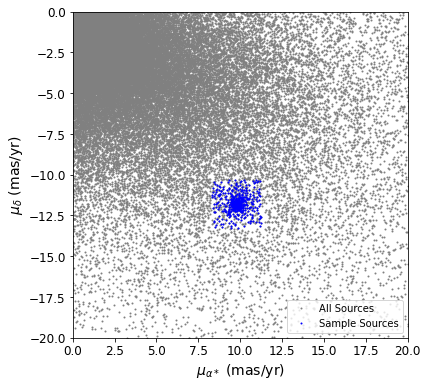

In [ ]:
fig = plt.figure(figsize=(6, 6))
plt.plot(allsource['pmra'], allsource['pmdec'], '.', color='gray', markersize=2., label="All Sources")
plt.plot(samplesource['pmra'], samplesource['pmdec'], '.', color='blue', markersize=2., label="Sample Sources")

plt.xlabel(r"$\mu_{\alpha*}$ (mas/yr)")
plt.ylabel(r"$\mu_{\delta}$ (mas/yr)")

plt.xticks()
plt.yticks()

plt.xlim(0,20)
plt.ylim(-20,0)

plt.legend()
plt.show()

Parallax Distribution

In [ ]:
bins_all = np.arange(allsource['parallax'].min(), allsource['parallax'].max(), .01)
bins_sam = np.arange(samplesource['parallax'].min(), samplesource['parallax'].max(), .01)

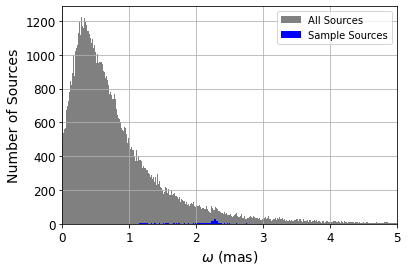

In [ ]:
plt.figure(figsize=(6, 4))
allsource['parallax'].hist(bins=bins_all, color='gray', label="All Sources")
samplesource['parallax'].hist(bins=bins_sam, color='b', label="Sample Sources")

plt.xlabel(r"$\omega$ (mas)")
plt.ylabel("Number of Sources")

plt.xlim([0, 5])

plt.xticks()
plt.yticks()

plt.legend()
plt.show()

Color Magnitude Diagram

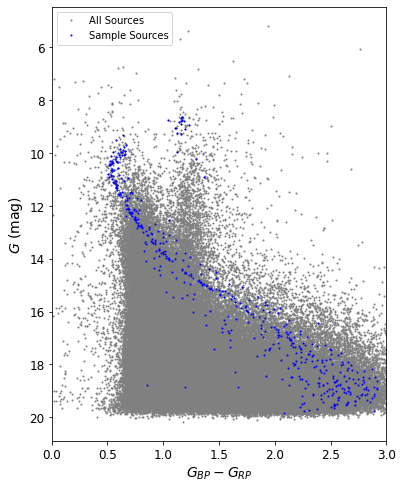

In [ ]:
plt.figure(figsize=(6, 8))
plt.plot(allsource['bp_rp'], allsource['phot_g_mean_mag'], '.', color='gray', markersize=2., label="All Sources")
plt.plot(samplesource['bp_rp'], samplesource['phot_g_mean_mag'], '.', color='b', markersize=2., label="Sample Sources")

plt.xlabel(r"$G_{BP}-G_{RP}$")
plt.ylabel(r"$G$ (mag)")

plt.xlim([0., 3.])

plt.gca().invert_yaxis()
plt.legend()
plt.show()

In [ ]:
print('All Sources = %d \nSample Sources = %d' %(len(allsource), len(samplesource)))

All Sources = 119718 
Sample Sources = 512


---

####Let's Start the Game!!!

Normalize the data

In [ ]:
df = samplesource[["pmra", "pmdec", "parallax"]]
df = df.to_numpy().astype("float32", copy = False)

In [ ]:
stscaler_df = StandardScaler().fit(df)
df_ = stscaler_df.transform(df)

In [ ]:
norm_pmra = df_[:,0]
norm_pmde = df_[:,1]
norm_para = df_[:,2]

Select some parameters to be calculated

In [ ]:
sample_data_dict = {
    'norm_pmra' : norm_pmra,
    'norm_pmde' : norm_pmde,
    'norm_para' : norm_para,
}

sample_data = pd.DataFrame(sample_data_dict)

Train Gaussian Mixture Model (GMM) with whole data, consider it models two gaussian components (field and cluster)

In [ ]:
gmm = GaussianMixture(n_components=2, max_iter=1000, covariance_type='full', random_state=None).fit(sample_data)

Calculate means, covariances and weights of trained/fitted models

In [ ]:
gmm.means_, gmm.covariances_, gmm.weights_

(array([[ 0.02647034, -0.05696691,  0.47934096],
        [-0.08784734,  0.18905651, -1.59079226]]),
 array([[[ 0.71579776,  0.06872797,  0.05649506],
         [ 0.06872797,  0.70201271, -0.00519505],
         [ 0.05649506, -0.00519505,  0.23980225]],
 
        [[ 1.9331458 , -0.15852605,  0.16801871],
         [-0.15852605,  1.94242454, -0.1055576 ],
         [ 0.16801871, -0.1055576 ,  0.22972609]]]),
 array([0.76844922, 0.23155078]))

Calculate the probabilities of the whole data

In [ ]:
pred_data = gmm.predict_proba(sample_data)

In [ ]:
pred_data

array([[4.24172644e-01, 5.75827356e-01],
       [1.00850836e-03, 9.98991492e-01],
       [9.97275566e-01, 2.72443353e-03],
       ...,
       [2.79986015e-05, 9.99972001e-01],
       [9.97348539e-01, 2.65146133e-03],
       [4.03072639e-04, 9.99596927e-01]])

Check the calculated probabilities

(0.0, 1.0)

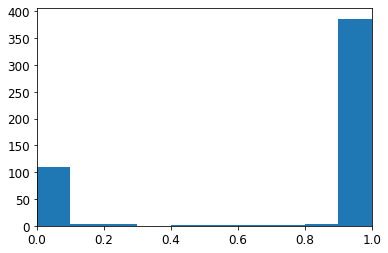

In [ ]:
plt.hist(pred_data[:,0], bins=[0., .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.])
plt.xlim([0., 1.])

(0.0, 1.0)

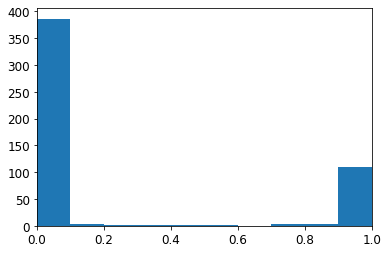

In [ ]:
plt.hist(pred_data[:,1], bins=[0., .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.])
plt.xlim([0., 1.])

---

####The Probabilities

Input the calculated probabilities to sample source dataframe. Run the below codes until the Visualization II (Result). Because of the gaussian mixture can't determine which one is the cluster or the field stars, you could change the column. If the result of the `pred_data[:,0]` shows the field stars in the Vector Point Diagram (VPD), you should change it to `pred_data[:,1]`.   

In [ ]:
samplesource['prob'] = pred_data[:,0]

Determine the probability member classes. According to Agarwal et al. (2021), there are three main classes: `member_high` is high probability members ($P(x) \ge 0.6$); `member_moder` is moderate probability members ($0.2 \lt P(x) \lt 0.6$); and `member_low` is low probability members ($P(x) \le 0.2$). There is also one additional class: `member_ultra` is ultra-high probability members ($P(x) \ge 0.8$).  

In [ ]:
member_ultra = samplesource[samplesource['prob'] >= .8].reset_index(drop=True)
member_high  = samplesource[samplesource['prob'] >= .6].reset_index(drop=True)
member_moder = samplesource[(samplesource['prob'] > .2) & (samplesource['prob'] < .6)].reset_index(drop=True)
member_low   = samplesource[samplesource['prob'] <= .2].reset_index(drop=True)

Stars with a high probability values are automatically considered as members of the cluster. Stars with medium probability values ​​can be considered as the cluster members if their parallax values lie in the parallax value range of ultra-high probability cluster members. We can calculate it using the code below and consider it as `member_incl`.

In [ ]:
member_incl = member_moder[(member_moder['parallax'] >= member_ultra['parallax'].min()) & 
                           (member_moder['parallax'] <= member_ultra['parallax'].max())].reset_index(drop=True)

In [ ]:
print('Sample Sources = %d \nHigh probability member sources (p >= 0.6) = %d \nModerate probability member sources (0.2 <= p < 0.6) = %d \nIncluded moderate probability member sources = %d' %(len(samplesource),
                                                                                                                                          len(samplesource[samplesource['prob'] >= .6]),
                                                                                                                                          len(samplesource[(samplesource['prob'] >= .2) & (samplesource['prob'] < .6)]),
                                                                                                                                          len(member_incl)))

Sample Sources = 512 
High probability member sources (p >= 0.6) = 392 
Moderate probability member sources (0.2 <= p < 0.6) = 7 
Included moderate probability member sources = 0


Combine `member_high` and `member_incl` to get all members. 

In [ ]:
member_all = pd.concat([member_high, member_incl]).sort_values(by=['prob'], ascending=False).reset_index(drop=True)

In [ ]:
len(member_all)

392

Calculate some important parameters

In [ ]:
mean_para_val = np.mean(member_all['parallax'] + 0.013)
mean_para_std = np.std(member_all['parallax'] + 0.013)

member_dist = 1000./(member_all['parallax'] + 0.013)

In [ ]:
mean_pmra_val = np.mean(member_all['pmra'])
mean_pmra_std = np.std(member_all['pmra'])
mean_pmde_val = np.mean(member_all['pmdec'])
mean_pmde_std = np.std(member_all['pmdec'])
mean_dist_val = np.mean(member_dist )
mean_dist_std = np.std(member_dist )

In [ ]:
mean_pmra_val, mean_pmra_std, mean_pmde_val, mean_pmde_std, mean_para_val, mean_para_std, mean_dist_val, mean_dist_std

(9.823116215598855,
 0.5055702001747391,
 -11.780912034884059,
 0.48093878769976467,
 2.2866083044054504,
 0.19705662647295802,
 440.30199574483095,
 35.08529087809963)

---

####Visualization II (Result)

Probability Distribution

In [ ]:
bins_samp = np.arange(samplesource['prob'].min(), samplesource['prob'].max(), .1)
bins_high = np.arange(samplesource['prob'][samplesource['prob'] >= .6].min(), samplesource['prob'][samplesource['prob'] >= .6].max(), .1)
bins_mode = np.arange(samplesource['prob'][(samplesource['prob'] >= .2) & (samplesource['prob'] < .6) & 
                                       (samplesource['parallax'] >= member_ultra['parallax'].min()) & 
                                       (samplesource['parallax'] <= member_ultra['parallax'].max())].min(), 
                      samplesource['prob'][(samplesource['prob'] >= .2) & (samplesource['prob'] < .6) & 
                                       (samplesource['parallax'] >= member_ultra['parallax'].min()) & 
                                       (samplesource['parallax'] <= member_ultra['parallax'].max())].max(), .1)

bins = np.linspace(0., 1., 10)

ValueError: ignored

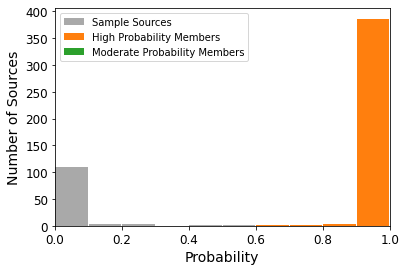

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist(samplesource['prob'], bins=[0., .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.], color='darkgray', rwidth=.975, label="Sample Sources")
plt.hist(member_high['prob'], bins=[.6, .7, .8, .9, 1.], color='tab:orange', rwidth=.975, label="High Probability Members")
plt.hist(member_incl['prob'], bins=[.2, .3, .4, .5, .6], color='tab:green', rwidth=.975, label="Moderate Probability Members")

plt.xlabel("Probability")
plt.ylabel("Number of Sources")

plt.xlim([0., 1.])

plt.xticks()
plt.yticks()

plt.legend()
plt.show()

Vector Point Diagram

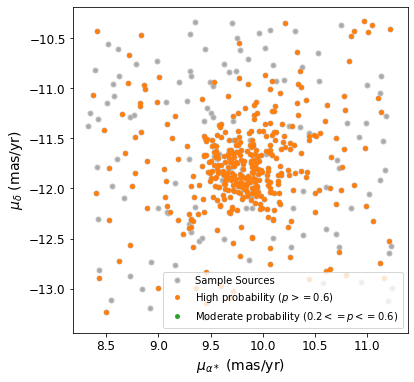

In [ ]:
fig = plt.figure(figsize=(6, 6))
plt.plot(samplesource['pmra'], samplesource['pmdec'], 'o', mec='silver', mfc='darkgray', markersize=5., label="Sample Sources")
plt.plot(member_high['pmra'], member_high['pmdec'], 'o', mfc='tab:orange', mec='None', markersize=5., label=r"High probability ($p >= 0.6$)")
plt.plot(member_incl['pmra'], member_incl['pmdec'], 'o', mfc='tab:green', mec='None', markersize=5., label=r"Moderate probability ($0.2 <= p <= 0.6$)")

plt.xlabel(r"$\mu_{\alpha*}$ (mas/yr)")
plt.ylabel(r"$\mu_{\delta}$ (mas/yr)")

plt.xticks()
plt.yticks()

plt.legend()
plt.show()

Parallax and proper motions (pmra & pmdec) distribution

In [ ]:
bins_samp = np.arange(samplesource['parallax'].min(), samplesource['parallax'].max(), .05)
bins_high = np.arange(member_high['parallax'].min(), member_high['parallax'].max(), .05)
#bins_mode = np.arange(member_incl['parallax'].min(), member_incl['parallax'].max(), .05)

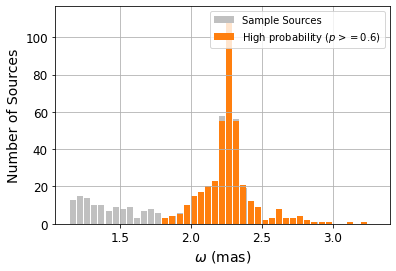

In [ ]:
plt.figure(figsize=(6, 4))
samplesource['parallax'].hist(bins=bins_samp, color='silver', rwidth=.85, label="Sample Sources")
member_high['parallax'].hist(bins=bins_high, color='tab:orange', rwidth=.85, label=r"High probability ($p >= 0.6$)")
#member_incl['parallax'].hist(bins=bins_mode, color='tab:green', rwidth=.85, label=r"Moderate probability ($0.2 <= p <= 0.6$)")

plt.xlabel(r"$\omega$ (mas)")
plt.ylabel("Number of Sources")

plt.xticks()
plt.yticks()

plt.legend()
plt.show()

Spatial distribution

In [ ]:
coor_all  = SkyCoord(ra=samplesource.ra, dec=samplesource.dec, frame='icrs', unit=(u.deg, u.deg))
coor_high = SkyCoord(ra=member_high.ra, dec=member_high.dec, frame='icrs', unit=(u.deg, u.deg))
coor_mid  = SkyCoord(ra=member_incl.ra, dec=member_incl.dec, frame='icrs', unit=(u.deg, u.deg))

In [ ]:
ra_all  = coor_all.ra.wrap_at(180 * u.deg).degree
de_all  = coor_all.dec.degree

ra_high = coor_high.ra.wrap_at(180 * u.deg).degree
de_high = coor_high.dec.degree

ra_mid  = coor_mid.ra.wrap_at(180 * u.deg).degree
de_mid  = coor_mid.dec.degree

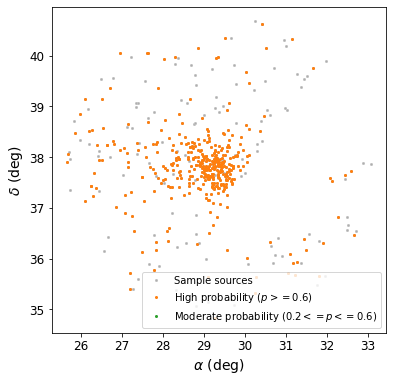

In [ ]:
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot()
plt.plot(ra_all, de_all, 'o', mec='silver', mfc='darkgray', markersize=2., label="Sample sources")
plt.plot(ra_high, de_high, 'o', mfc='tab:orange', markersize=2., label=r"High probability ($p >= 0.6$)")
plt.plot(ra_mid, de_mid, 'o', mfc='tab:green', markersize=2., label=r"Moderate probability ($0.2 <= p <= 0.6$)")

plt.xlabel(r'$\alpha$ (deg)')
plt.ylabel(r'$\delta$ (deg)')

plt.legend()
#ax.set_xticklabels([358.25, 358.5, 358.75, 359.0, 359.25, 359.5, 359.75, 0.00, 0.25], fontsize=18.)
plt.show()

Color Magnitude Diagram

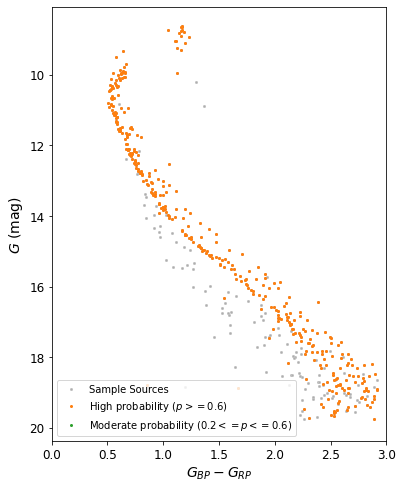

In [ ]:
plt.figure(figsize=(6, 8))
plt.plot(samplesource['bp_rp'], samplesource['phot_g_mean_mag'], 'o', mec='silver', mfc='darkgray', markersize=2., label="Sample Sources")
plt.plot(member_high['bp_rp'], member_high['phot_g_mean_mag'], 'o', color='tab:orange', markersize=2., label=r"High probability ($p >= 0.6$)")
plt.plot(member_incl['bp_rp'], member_incl['phot_g_mean_mag'], 'o', color='tab:green', markersize=2., label=r"Moderate probability ($0.2 <= p <= 0.6$)")

plt.xlabel(r"$G_{BP}-G_{RP}$")
plt.ylabel(r"$G$ (mag)")

plt.xlim([0., 3.])

plt.gca().invert_yaxis()
plt.legend()
plt.show()

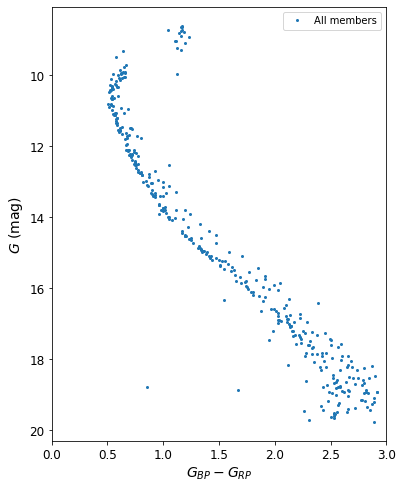

In [ ]:
plt.figure(figsize=(6, 8))
plt.plot(member_all['bp_rp'], member_all['phot_g_mean_mag'], 'o', color='tab:blue', markersize=2., label=r"All members")

plt.xlabel(r"$G_{BP}-G_{RP}$")
plt.ylabel(r"$G$ (mag)")

plt.xlim([0., 3.])

plt.gca().invert_yaxis()
plt.legend()
plt.show()



---


####Tasks

You can also try with other data! <br>
* M 67 = [gaiaedr3_150_M67.csv](https://drive.google.com/file/d/1eX41_G_W1eP3-9Qxi0OzM-BAIQOAQjbU/view?usp=sharing) <br>
* NGC 7789 = [gaiaedr3_45_NGC7789.csv](https://drive.google.com/file/d/12TAgIMdPgFUTtpL2jely0Y7umQCRhcEy/view?usp=sharing) 



## 6. References

1. Agarwal, Manan, et al. "ML-MOC: Machine Learning (kNN and GMM) based Membership determination for Open Clusters." Monthly Notices of the Royal Astronomical Society 502.2 (2021): 2582-2599.
2. Gaia Collaboration. "VizieR Online Data Catalog: Gaia DR2 (Gaia Collaboration, 2018)." VizieR Online Data Catalog (2018): I-345.
3. McLachlan, G. and Peel., D. "Finite mixture models." (2000).
4. Pedregosa, Fabian, et al. "Scikit-learn: Machine learning in Python." the Journal of machine Learning research 12 (2011): 2825-2830.










